# LSTM model creation

In [35]:
# imports

import time
import os
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score, accuracy_score, precision_score, f1_score, recall_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding

## 1. Data loading and exploration

In [2]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [3]:
ag_news_train_df.shape

(120000, 3)

In [4]:
ag_news_test_df.shape

(7600, 3)

In [5]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [6]:
amazon_reviews_df.shape

(17340, 4)

In [7]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [8]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot:>

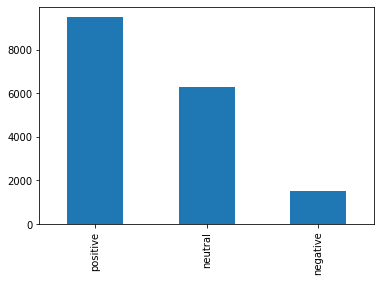

In [9]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot:>

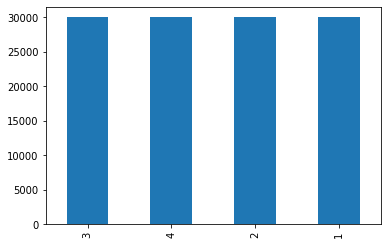

In [10]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

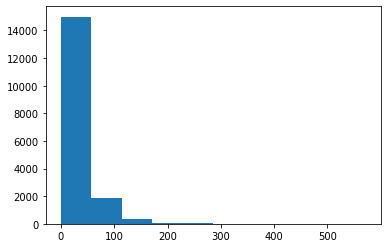

In [11]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

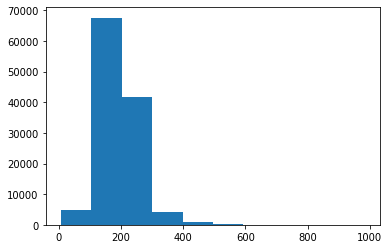

In [12]:
plt.hist(ag_news_train_df.Description.str.len())

In [13]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [14]:
amazon_reviews_df.dropna(inplace=True)

## 2. Train/Val/Test split

In [15]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [16]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [17]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.33)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [18]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [19]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [20]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [21]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.33)

In [22]:
# use later on when we want to perform hyper parameter tuning

# np.random.seed(42)
# reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
#                                      replace=False, size=y_train_reviews.shape[0]//2)
# news_train_idx = np.random.choice(y_train_news.shape[0], 
#                                      replace=False, size=y_train_news.shape[0]//8)

# X_train_reviews_half = X_train_reviews_tr[reviews_train_idx,:]
# y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]
# X_train_news_eighth = X_train_news_tr[news_train_idx,:]
# y_train_news_eighth = y_train_news.iloc[news_train_idx]

In [23]:
# checking if models are saved

best_model_nn_reviews_is_saved = os.path.exists('models/best_model_nn_reviews.sav')
best_model_nn_news_is_saved = os.path.exists('models/best_model_nn_news.sav')
best_model_svm_reviews_is_saved = os.path.exists('models/best_model_svm_reviews.sav')
best_model_svm_news_is_saved = os.path.exists('models/best_model_svm_news.sav')

## 3. Model development - LSTM

### 3.1. Reviews data set

In [24]:
# setting the vocabulary and sentence length
voc_size = 5000
sent_length = 40

In [25]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [26]:
def preprocessing(X, y):
    X.drop(['cleaned_review_length', 'review_score'], axis=1, inplace=True)
    corpus = X['cleaned_review'].values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
        
    y = pd.get_dummies(y)
    
    X = np.array(embedded_docs)
    y = np.array(y)
    
    return (X, y)

In [27]:
X_train, y_train = preprocessing(X_train, y_train)
X_valid, y_valid = preprocessing(X_valid, y_valid)
X_test, y_test = preprocessing(X_test, y_test)

In [28]:
# creating the base LSTM model

embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 10, batch_size = 100)

Epoch 1/10
93/93 [==============================] - 9s 71ms/step - loss: 0.7794 - accuracy: 0.6437 - val_loss: 0.5847 - val_accuracy: 0.7398
Epoch 2/10
93/93 [==============================] - 6s 66ms/step - loss: 0.4947 - accuracy: 0.7957 - val_loss: 0.4871 - val_accuracy: 0.7922
Epoch 3/10
93/93 [==============================] - 6s 66ms/step - loss: 0.3869 - accuracy: 0.8506 - val_loss: 0.4886 - val_accuracy: 0.8058
Epoch 4/10
93/93 [==============================] - 6s 66ms/step - loss: 0.3170 - accuracy: 0.8828 - val_loss: 0.4864 - val_accuracy: 0.8173
Epoch 5/10
93/93 [==============================] - 7s 71ms/step - loss: 0.2702 - accuracy: 0.9029 - val_loss: 0.4881 - val_accuracy: 0.8235
Epoch 6/10
93/93 [==============================] - 7s 75ms/step - loss: 0.2317 - accuracy: 0.9178 - val_loss: 0.5227 - val_accuracy: 0.8211
Epoch 7/10
93/93 [==============================] - 9s 100ms/step - loss: 0.1967 - accuracy: 0.9342 - val_loss: 0.5529 - val_accuracy: 0.8263
Epoch 8/10
9

The results show that the model is overfitting the training data and not generalizing well to the validation data. This can be seen from the increasing difference between training accuracy and validation accuracy as the number of epochs increases.

The training accuracy increases up to 95.6% while the validation accuracy only reaches 82.15%. This suggests that the model is memorizing the training data rather than learning the underlying patterns that can be generalized to the validation set.

The loss is also decreasing on the training set, but increasing on the validation set. This further supports the overfitting issue.

To address the overfitting issue, we will try using regularization techniques like dropout, or simplifying the model architecture.

In [31]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test,y_pred)

0.8278546712802768

In [32]:
precision_score(y_test,y_pred, average='weighted')

0.8260489804872534

In [33]:
recall_score(y_test,y_pred, average='weighted')

0.8278546712802768

In [34]:
f1_score(y_test,y_pred, average='weighted')

0.8254018450419489

The test accuracy is 0.827 which is very similar to the validation results, therefore we will try to add dropout layers, or simplify the model architecture.

We are using accuracy at the moment, we will later on focus on more metrics, and see in greated details how to best optimize the model.

#### LSTM updated model - dropout added

In [36]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 40, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 10, batch_size = 100)

Epoch 1/10
93/93 [==============================] - 12s 79ms/step - loss: 0.8297 - accuracy: 0.6093 - recall: 0.4619 - precision: 0.6572 - val_loss: 0.6131 - val_accuracy: 0.7400 - val_recall: 0.6760 - val_precision: 0.7923
Epoch 2/10
93/93 [==============================] - 6s 63ms/step - loss: 0.5325 - accuracy: 0.7845 - recall: 0.7305 - precision: 0.8259 - val_loss: 0.4946 - val_accuracy: 0.7887 - val_recall: 0.7481 - val_precision: 0.8247
Epoch 3/10
93/93 [==============================] - 6s 69ms/step - loss: 0.4166 - accuracy: 0.8359 - recall: 0.8095 - precision: 0.8582 - val_loss: 0.4717 - val_accuracy: 0.8080 - val_recall: 0.7924 - val_precision: 0.8234
Epoch 4/10
93/93 [==============================] - 6s 68ms/step - loss: 0.3558 - accuracy: 0.8644 - recall: 0.8509 - precision: 0.8783 - val_loss: 0.4558 - val_accuracy: 0.8180 - val_recall: 0.8012 - val_precision: 0.8336
Epoch 5/10
93/93 [==============================] - 6s 68ms/step - loss: 0.3007 - accuracy: 0.8896 - recall

In [38]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test

y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test, y_pred)

0.8284313725490197

In [39]:
precision_score(y_test,y_pred, average='weighted')

0.8273031494644975

In [40]:
recall_score(y_test,y_pred, average='weighted')

0.8284313725490197

In [41]:
f1_score(y_test,y_pred, average='weighted')

0.827476634277903

After adding two dropout layers with the probability of 0.3, we get an accuracy of 0.828 which isn't an improvement really. We will now try to change the model architecture, and see what we can get.

We will change the voc_size and the sent_length to see if that can make the results better.

In [42]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 100
embedding_vector_features = 60

In [43]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [44]:
def preprocessing(X, y):
    X.drop(['cleaned_review_length', 'review_score'], axis=1, inplace=True)
    corpus = X['cleaned_review'].values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
        
    y = pd.get_dummies(y)
    
    X = np.array(embedded_docs)
    y = np.array(y)
    
    return (X, y)

In [45]:
X_train, y_train = preprocessing(X_train, y_train)
X_valid, y_valid = preprocessing(X_valid, y_valid)
X_test, y_test = preprocessing(X_test, y_test)

In [46]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 60)           600000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              128800    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 729,403
Trainable params: 729,403
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 3, batch_size = 64)

Epoch 1/3
146/146 [==============================] - 39s 232ms/step - loss: 0.7192 - accuracy: 0.6792 - val_loss: 0.5143 - val_accuracy: 0.7815
Epoch 2/3
146/146 [==============================] - 44s 299ms/step - loss: 0.4196 - accuracy: 0.8306 - val_loss: 0.4371 - val_accuracy: 0.8248
Epoch 3/3
146/146 [==============================] - 44s 302ms/step - loss: 0.3047 - accuracy: 0.8838 - val_loss: 0.4447 - val_accuracy: 0.8300


In [49]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test,y_pred)

0.8373702422145328

In [50]:
precision_score(y_test,y_pred, average='weighted')

0.8408864917184785

In [51]:
recall_score(y_test,y_pred, average='weighted')

0.8373702422145328

In [52]:
f1_score(y_test,y_pred, average='weighted')

0.8380719330360147

In [53]:
# best result is 83 % accuracy

### left-to-do

Perform the hyperparameter tuning using kerastuner
- different dimensions of the LSTM layer
- multiple Dense layers and different dimensions
- different dropout probabilities
- voc_size
- embedding_size
- sent_length
- different activation function, maybe multiple dense layers with different activation functions

##### LSTM hyperparameter tuning

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))

In [ ]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())